In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph
%pip unstall -q -U langchain
%pip install -q -U langchain-google-genai
%pip install -U  langgraph tavily-python wikipedia langchain_community langgraph_sdk


In [34]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')


In [35]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=google_api_key,     # Provide the Google API key for authentication
)

In [4]:
from typing_extensions import TypedDict
from typing_extensions import Annotated
import operator

class State(TypedDict):
  question:str
  answer:str
  context: Annotated[list, operator.add]


In [13]:
import os
# Enter your Tavily API key
os.environ["TAVILY_API_KEY"] = "your_api_key"

In [24]:
from langchain_core.messages import HumanMessage, SystemMessage, SystemMessage, HumanMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

def search_tavily(state:State):

 tavily_search = TavilySearchResults(max_results=3)
 search_docs = tavily_search.invoke(state['question'])

 formmated_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
 return {"context":[formmated_docs]}

def search_wikipedia(state:State):
  search_docs = WikipediaLoader(query=state['question'], load_max_docs=3).load()
  formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
  return {"context":[formatted_docs]}


In [39]:
def generate_answer(state:State):
  question=state['question']
  context=state['context']
  answer_template = """Generate the answer of this {question} with this {context}"""
  answer_instructions = answer_template.format(question=question,context=context)

  answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content="Answer the Question")])

  return {"answer":answer}


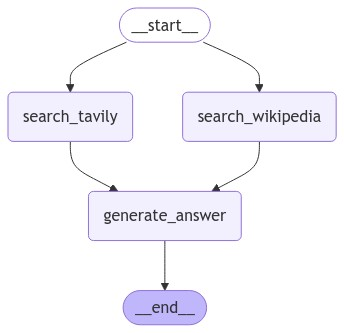

In [40]:
from langgraph.graph import START, StateGraph, END
from IPython.display import display, Image

builder = StateGraph(State)
builder.add_node("search_tavily", search_tavily)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_tavily")
builder.add_edge(START, "search_wikipedia")
builder.add_edge("search_tavily","generate_answer")
builder.add_edge("search_wikipedia","generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
result = graph.invoke({"question": "What were the key financial results for Nvidia in Q2 2024?"})
result["answer"].content


"Here are the key financial results for Nvidia in Q2 2024, based on the provided documents:\n\n* **Revenue:** $13.51 billion, more than double the revenue from the same quarter last year.\n* **GAAP Net Income:** $6.2 billion, or $2.48 per share, a significant increase from $656 million, or $0.26 per share, in Q2 2023.\n* **Adjusted EPS:** $2.70.\n* **Q3 2024 Revenue Guidance:** Nvidia expects revenue of $16 billion for the third quarter of 2024.\n\nThese results highlight Nvidia's strong performance, driven by high demand for its data center products, particularly those based on the Hopper architecture. \n"